# AiDM Assignment 1
## Group 32
Eric Prehn s2724731 and Chloe Gao

#### Import libraries and Data set Exploration

In [2]:
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import time
import itertools


os.getcwd()
import warnings
warnings.filterwarnings("ignore")

# load data from file
# data = pd.read_csv('movies.csv',header=None)     
movies = pd.read_table('movies.dat',sep='::',names=['MovieID','Title','Genre'])
ratings = pd.read_table('ratings.dat',sep='::',names=['UserID','MovieID','Rating','Timestamp'])
users = pd.read_table ('users.dat',sep='::',names=['UserID','Gender','Age','Occupation','Zip-code'])


#####################################################################################################
##              Data Exploration                                                                   ##
#####################################################################################################                                                                                               

# merge movie and rating tables
movie_rating = pd.merge(ratings, movies, on =['MovieID'], how ='left')
#movie_rating.head()

avg_rating_movie=movie_rating.groupby('Title').agg({'Rating':[np.size,np.mean]})
avg_rating_movie.rename({'size':'times_rated','mean':'avg_rating_movie'}, axis=1,inplace=True)

avg_rating_user=movie_rating.groupby('UserID').agg({'Rating':[np.size,np.mean]})
avg_rating_user.rename({'size':'movies_rated','mean':'avg_rating_user'}, axis=1,inplace=True)
#avg_rating_user

avg_rating_movie[avg_rating_movie['Rating']['times_rated'] >=150].sort_values([('Rating','avg_rating_movie')] ,ascending=False).head()

#add the global average rating, the average rating per item, the average rating per user
movie_rating['global_average_rating']=movie_rating['Rating'].mean()
movie_rating = pd.merge(movie_rating, avg_rating_movie, on =['Title'], how ='left')
movie_rating = pd.merge(movie_rating, avg_rating_user, on =['UserID'], how ='left')


movie_rating.rename({'Rating_x': 'Rating', "('Rating', 'size')_x": 'times_rated',
                     "('Rating', 'mean')_x":'R_item ',"(Rating_y, size)":'movies_rated',
                     "(Rating_y, mean)":'R_user'}, axis=1,inplace=True)

global_avg=3.581564  # across entire set

#################################################################################################################
##                      Drop columns not required                                                              ##
#################################################################################################################


#small_movie_rating=movie_rating.drop(['Timestamp','Genre','Title','global_average_rating'] ,axis=1)
small_movie_rating=movie_rating.drop(movie_rating.columns[[3,4,5,6,7,9]] ,axis=1)
small_movie_rating.head()





,UserID,MovieID,Rating,"(Rating, avg_rating_movie)","(Rating, avg_rating_user)"
0,1,1193,5,4.390725,4.188679
1,1,661,3,3.464762,4.188679
2,1,914,3,4.154088,4.188679
3,1,3408,4,3.863878,4.188679
4,1,2355,5,3.854375,4.188679


### Convert Ratings data set to Numpy and use Numpy library from now on for efficiency

In [3]:
all_data=small_movie_rating.to_numpy()

print("Number of Movies present in set:" ,len(np.unique(all_data[:, 0])))  ##find number of users present in dataset
print("Number of Movies present in set:" ,len(np.unique(all_data[:,1])) ) #find number of movies present

Number of Movies present in set: 6040
Number of Movies present in set: 3706


### Reindex the movies
Since there are gaps in the Movie_id's, use dictionary to map the indices such that there are no gaps present (i.e 0 to 3705)

In [4]:
movies_present=set(all_data[:,1])
print("Movies present out of 3952:")
print(len(movies_present))

movie_dict={}
counter=1
for i in range(len(all_data[:,1])):
    
    if all_data[i,1] in movie_dict.values():
        
        continue
    else:
        movie_dict[counter]=all_data[i,1]
        counter=counter+1
#print(all_data)       
# swap keys and values 
new_movie_dict = dict([(value, key) for key, value in movie_dict.items()])
#print(new_movie_dict)
#print(new_movie_dict.keys())



for i in range(len(all_data[:,1])):
    all_data[i,1]=new_movie_dict[all_data[i,1]]
    
#print(all_data)

Movies present out of 3952:
3706


Movie_ID is now labelled from one to 3706, can access original ID using new_movie_dict.


## Create cross validation sets s.t every user is present in every set

Modulo 5 to split the sets:

In [5]:
X=all_data[:,0:3]

sets1=[]
sets2=[]
sets3=[]
sets4=[]
sets5=[]

# create 5 sets as follows:
for i in range(len(X[:,0])):
    if i % 5 == 0:
        sets1.append(X[i])
    if i % 5 == 1:
        sets2.append(X[i])
    if i % 5 == 2:
        sets3.append(X[i])
    if i % 5 == 3:
        sets4.append(X[i])
    if i % 5 == 4:
        sets5.append(X[i])
        
sets1=np.array(sets1)
sets2=np.array(sets2)
sets3=np.array(sets3)
sets4=np.array(sets4)
sets5=np.array(sets5)

print("Printing number of users present out of 6040 in each of the 5 created sets:")
print(len(np.unique(sets5[:,0])))
print(len(np.unique(sets4[:,0])))
print(len(np.unique(sets3[:,0])))
print(len(np.unique(sets2[:,0])))
print(len(np.unique(sets1[:,0])))
print("Printing number of Movies present out of 3076 in each of the 5 created  sets:")
print(len(np.unique(sets5[:,1])))
print(len(np.unique(sets4[:,1])))
print(len(np.unique(sets3[:,1])))
print(len(np.unique(sets2[:,1])))
print(len(np.unique(sets1[:,1])))



Printing number of users present out of 6040 in each of the 5 created sets:
6040
6040
6040
6040
6040
Printing number of Movies present out of 3076 in each of the 5 created  sets:
3472
3463
3472
3465
3473


## Create Training and Test sets

In [6]:
#Define 5 training sets 



trains=np.ndarray(shape=(4,800167,3))
trains[0]=np.concatenate((sets2,sets3,sets4,sets5), axis=0)
trains[1]=np.concatenate((sets1,sets3,sets4,sets5), axis=0)
trains[2]=np.concatenate((sets1,sets2,sets4,sets5), axis=0)
trains[3]=np.concatenate((sets1,sets2,sets3,sets5), axis=0)

trains_5=np.ndarray(shape=(5,800168,3))                            #has different dimensions
trains_5=np.concatenate((sets1,sets2,sets3,sets4), axis=0)


#Define 5 test sets 
tests=np.ndarray(shape=(4,200042,3))
tests[0]=sets1
tests[1]=sets2
tests[2]=sets3
tests[3]=sets4

tests_5=sets5                                                      #has different dimensions 






## Global Averages
Find the Global average rating for every one of the 5 training sets and then calculate RMSE and MAE scores.

In [7]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
import math as ma


global_averages=[]
#############################################################################
#               Find global averages
#############################################################################
for i in range(4):
    global_averages.append(np.mean(trains[i,:,2]))
global_averages.append(np.mean(trains_5[:,2]))
#print(global_averages)


global_rms=[]
global_mae=[]

global_train_rms=[]          
global_train_mae=[]

#############################################################################
#               Find RMSE and MAE for test sets
#############################################################################

def cross_val_global(predicted,test):
    
    y_predicted=[predicted]*(len(test[:,1]))
    y_actual=test[:,2]
    rms = ma.sqrt(mse(y_actual, y_predicted))
    Mae = mae(y_actual,y_predicted)
    #print(rms)
    #print(Mae)
    global_rms.append(rms)
    global_mae.append(Mae)


for i in range(4):
    cross_val_global(global_averages[i],tests[i])
cross_val_global(global_averages[4],tests_5)

#############################################################################
#               Find RMSE and MAE for training sets
#############################################################################

def cross_val_global_train(predicted,train_set):
    
    y_predicted=[predicted]*(len(train_set[:,2]))
    y_actual=train_set[:,2]
    rms = ma.sqrt(mse(y_actual, y_predicted))
    Mae = mae(y_actual,y_predicted)
    #print(rms)
    #print(Mae)
    global_train_rms.append(rms)
    global_train_mae.append(Mae)
    
    
for i in range(4):
    %time cross_val_global_train(global_averages[i],trains[i])
    
    
%time cross_val_global_train(global_averages[4],trains_5)


print(" Test CV Average RMSE for GlobalAverage:")
print(np.mean(global_rms))
print(" Test CV Average MAE for GlobalAverage:")
print(np.mean(global_mae))
print(" Train CV Average RMSE for GlobalAverage:")
print(np.mean(global_train_rms))
print(" Train CV Average MAE for GlobalAverage:")
print(np.mean(global_train_mae))

Wall time: 119 ms
Wall time: 117 ms
Wall time: 115 ms
Wall time: 117 ms
Wall time: 117 ms
 Test CV Average RMSE for GlobalAverage:
1.117101080832882
 Test CV Average MAE for GlobalAverage:
0.9338609201654926
 Train CV Average RMSE for GlobalAverage:
1.1171012023494238
 Train CV Average MAE for GlobalAverage:
0.9338608484351891


### Get matrix representation, for every one of the train sets and store all in 3d array


In [8]:
rating_matrices= np.full((5,6040,3706), np.nan)   # define 5 rating_matrices[User,Item] in a 3d array


for i in range(4):                                          # first 4 sets
    for j in range(len(trains[i])):
        user_index=int(trains[i][j][0]-1)
        movie_index=int(trains[i][j][1]-1)
        rating=int(trains[i][j][2])
        rating_matrices[i][user_index][movie_index]=rating

for j in range(len(trains_5)):                              # fifth set
        user_index=int(trains_5[j][0]-1)
        movie_index=int(trains_5[j][1]-1)
        rating=int(trains_5[j][2])
        rating_matrices[4][user_index][movie_index]=rating        

print(rating_matrices[0][0])


[nan  3.  3. ... nan nan nan]


### Finding average user and item ratings
Find the R_User average for every user, for each of the 5 training sets.
Along with R_items average for every Movie, for each of the 5 training sets.
<font color="red">(Note: use Numpy operations on the sparse 3D ndarray of 5 rating matrices)</font>

In [9]:
R_users=np.nanmean(rating_matrices, axis=2)                        #efficient Numpy function calculating averages across axes
R_items=np.nanmean(rating_matrices,axis=1)

print("Shape of R_Users for 5 sets")
print(R_users.shape)
print("Shape of R_Items for 5 sets")
print(R_items.shape)

User_gaps=np.argwhere(np.isnan(R_users))     #there are no gaps for users
Movie_gaps=np.argwhere(np.isnan(R_items))    #there are gaps for movies







Shape of R_Users for 5 sets
(5, 6040)
Shape of R_Items for 5 sets
(5, 3706)


With the average User ratings and average Movie ratings stored in the arrays seen in the cell above, the R_User and R_Item Naive approaches can be implemented:

## R_User Naive Approach RMSE and MAE

In [10]:
User_rms=[]                      #test sets results
User_mae=[]                      #test sets  results

User_train_rms=[]               #training sets results
User_train_mae=[]               #training sets results

######################################################################################
#                 TEST SET CV
######################################################################################
def cross_val_user(test,train_set_index):
    
    
    
    y_predicted=[]
    y_actual=test[:,2]
    
    for i in range(len(y_actual)):                                    # loop over total number of ratings in set
        user_index=int(test[i,0])-1                                 
        y_predicted.append(R_users[train_set_index][user_index])
    
     
    rms = ma.sqrt(mse(y_actual, y_predicted))
    Mae = mae(y_actual,y_predicted)
    #print(rms)
    #print(Mae)
    User_rms.append(rms)
    User_mae.append(Mae)
    

for i in range(4):
    cross_val_user(tests[i],i)
%time cross_val_user(tests_5,4)

######################################################################################
#                 TRAIN SET CV
######################################################################################


def cross_val_user_train(train_set,train_set_index):
    
    
    
    y_predicted=[]
    y_actual=train_set[:,2]
    
    for i in range(len(y_actual)):
        user_index=int(train_set[i,0])-1
        y_predicted.append(R_users[train_set_index][user_index])
    
     
    rms = ma.sqrt(mse(y_actual, y_predicted))
    Mae = mae(y_actual,y_predicted)
    #print(rms)
    #print(Mae)
    User_train_rms.append(rms)
    User_train_mae.append(Mae)
    
for i in range(4):
    cross_val_user_train(trains[i],i)
%time cross_val_user(trains_5,4)

######################################################################################
#                 Print Results
######################################################################################
print("R_User Naive Approach: \n")
print(" Test CV Average RMSE for User_Average:")
print(np.mean(User_rms))
print("Test CV Average MAE for User_Average:")
print(np.mean(User_mae))

print("Train CV Average RMSE for User_Average:")
print(np.mean(User_train_rms))
print("Train CV Average MAE for User_Average:")
print(np.mean(User_train_mae))

Wall time: 163 ms
Wall time: 674 ms
R_User Naive Approach: 

 Test CV Average RMSE for User_Average:
1.0339802556865358
Test CV Average MAE for User_Average:
0.8278023055773946
Train CV Average RMSE for User_Average:
1.0275996707443207
Train CV Average MAE for User_Average:
0.8227245948376559


## R_Item Naive Approach
Create new R_Items 2d array that inserts the global average into where there are gaps

In [11]:
R_items_no_gaps=np.nan_to_num(R_items, copy=True, nan=np.mean(global_averages))

Item_rms=[]                     #test sets
Item_mae=[]                     #test sets

Item_train_rms=[]               #training sets
Item_train_mae=[]               #training sets


######################################################################################
#                 TEST SET CV
######################################################################################
def cross_val_item(test,train_set_index):
    
    
    
    y_predicted=[]
    y_actual=test[:,2]
    
    for i in range(len(y_actual)):
        item_index=int(test[i,1])-1
        y_predicted.append(R_items_no_gaps[train_set_index][item_index])
    
     
    rms = ma.sqrt(mse(y_actual, y_predicted))
    Mae = mae(y_actual,y_predicted)
    #print(rms)
    #print(Mae)
    Item_rms.append(rms)
    Item_mae.append(Mae)
    

for i in range(4):
    cross_val_item(tests[i],i)
%time cross_val_item(tests_5,4)

######################################################################################
#                 Train SET CV
######################################################################################
def cross_val_item_train(train_set,train_set_index):
    
    
    
    y_predicted=[]
    y_actual=train_set[:,2]
    
    for i in range(len(y_actual)):
        item_index=int(train_set[i,1])-1
        y_predicted.append(R_items_no_gaps[train_set_index][item_index])
    
     
    rms = ma.sqrt(mse(y_actual, y_predicted))
    Mae = mae(y_actual,y_predicted)
    #print(rms)
    #print(Mae)
    Item_train_rms.append(rms)
    Item_train_mae.append(Mae)
    

for i in range(4):
    cross_val_item_train(trains[i],i)
%time cross_val_item_train(trains_5,4)
######################################################################################
#                 Print Results
######################################################################################
print("R_Item Naive Approach: \n")
print("Test CV Average RMSE for Item_Average:")
print(np.mean(Item_rms))
print("Test CV Average MAE for Item_Average:")
print(np.mean(Item_mae))
print("Train CV Average RMSE for Item_Average:")
print(np.mean(Item_train_rms))
print("Train CV Average MAE for Item_Average:")
print(np.mean(Item_train_mae))

    

Wall time: 164 ms
Wall time: 675 ms
R_Item Naive Approach: 

Test CV Average RMSE for Item_Average:
0.9793904287300869
Test CV Average MAE for Item_Average:
0.7823151737090113
Train CV Average RMSE for Item_Average:
0.9742267101473943
Train CV Average MAE for Item_Average:
0.7783447258596728


## Naive Approach Regression

Want to create the input matrix A of columns [R_user,R_item,1] for all 5 sets. Can then apply np.linalg.lstsq() to get the corresponding parameters x=$[\alpha, \beta ,\gamma]^T$ that approximate $Ax=b$, where $b$ is the column of Ratings.


In [12]:
start = time.time()  

lstsq_parameters=[]   #define arrays to store the least squares parameters
  
input_matrices=[]
input_matrices_test=[]

######################################################################################
#                 Run least squares over training set
######################################################################################

def create_parameters(set_considered,set_considered_index):
    A=np.zeros(shape=(len(set_considered[:,0]),3))                          # create empty input matrix A 
    A[:,2]=1
    b=set_considered[:,2]
    for i in range(len(set_considered[:,0])):
        item_index=int(set_considered[i,1])-1
        user_index=int(set_considered[i,0])-1
        A[i,1]=R_items[set_considered_index][item_index]
        A[i,0]=R_users[set_considered_index][user_index]
    lstsq_parameters.append(np.linalg.lstsq(A,b)[0])
    input_matrices.append(A)
    
        
    
    
# Create for all 5 training sets
for i in range(4):
    create_parameters(trains[i],i)
create_parameters(trains_5,4)


######################################################################################
#                 Create test matrices consisting of rows [R_user,R_item,1]
######################################################################################

#Additionally create 5 A matrices for the test sets
def create_test_matrices(set_considered,set_considered_index):
    A=np.zeros(shape=(len(set_considered[:,0]),3))                           
    A[:,2]=1
    for i in range(len(set_considered[:,0])):
        item_index=int(set_considered[i,1])-1
        user_index=int(set_considered[i,0])-1
        A[i,1]=R_items_no_gaps[set_considered_index][item_index]                   # but now use R_items_no_gaps (setting movies that aren't present in the training set to global average)
        A[i,0]=R_users[set_considered_index][user_index]
    input_matrices_test.append(A)
    
        
# Create 5 test A matrices
for i in range(4):
    create_test_matrices(tests[i],i)
create_test_matrices(tests_5,4)

    
######################################################################################
#                 Print Least Squares Parameters
######################################################################################

print("The least square parameters [alpha,beta,gamma] for the 5 Cross-validation sets are: \n")
print(lstsq_parameters)
print("\n")

end = time.time()
print("Time required for creating 5 input matrices and running 5 least squares:")
print(end - start)

The least square parameters [alpha,beta,gamma] for the 5 Cross-validation sets are: 

[array([ 0.78088176,  0.87466452, -2.34820346]), array([ 0.78203728,  0.87477378, -2.35213151]), array([ 0.78313913,  0.87512685, -2.35776626]), array([ 0.78181512,  0.87488942, -2.35195194]), array([ 0.78183177,  0.87524725, -2.35326143])]


Time required for creating 5 input matrices and running 5 least squares:
7.317636013031006


## Regression Naive Approach Rmse and Mae


In [13]:
start = time.time() 

regression_rms_test=[]
regression_mae_test=[]

regression_rms_train=[]
regression_mae_train=[]

######################################################################################
#                 Train set CV
######################################################################################
def cross_val_regression_train(set_considered,set_considered_index):
    predicted=np.dot(input_matrices[set_considered_index],lstsq_parameters[set_considered_index])
    predicted[predicted>5]=5
    predicted[predicted<1]=1
    rms = ma.sqrt(mse(set_considered[:,2], predicted))
    Mae = mae(set_considered[:,2], predicted)
    #print(rms)
    #print(Mae)
    regression_rms_train.append(rms)
    regression_mae_train.append(Mae)
    
for i in range(4):
    cross_val_regression_train(trains[i],i)
cross_val_regression_train(trains_5,4)

######################################################################################
#                 Test set CV
######################################################################################
def cross_val_regression_test(set_considered,set_considered_index):
    predicted=np.dot(input_matrices_test[set_considered_index],lstsq_parameters[set_considered_index])
    predicted[predicted>5]=5
    predicted[predicted<1]=1
    rms = ma.sqrt(mse(set_considered[:,2], predicted))
    Mae = mae(set_considered[:,2], predicted)
    #print(rms)
    #print(Mae)
    regression_rms_test.append(rms)
    regression_mae_test.append(Mae)

for i in range(4):
    cross_val_regression_test(tests[i],i)
cross_val_regression_test(tests_5,4)

######################################################################################
#                 Print Results
######################################################################################
print("Regression Naive Approach: \n")
print("Train CV Average RMSE:")
print(np.mean(regression_rms_train))
print("Train CV Average MAE:")
print(np.mean(regression_mae_train))
print("Test CV Average RMSE:")
print(np.mean(regression_rms_test))
print("Test CV Average MAE:")
print(np.mean(regression_mae_test))

end = time.time()
print("Time required for calculating rmse and mae for 5 sets:")
print(end - start)

Regression Naive Approach: 

Train CV Average RMSE:
0.9145644924920335
Train CV Average MAE:
0.7248162122488123
Test CV Average RMSE:
0.9241080280579184
Test CV Average MAE:
0.7323378961899041
Time required for calculating rmse and mae for 5 sets:
0.1361234188079834


# UV Decomposition



Approximate rating matrix $M$ with a matrix $P=UV$ using grdient descent.
### Method
**First:** Randomly initialize U and V entries, uniformly distributed about the value $\sqrt{\frac{a}{d}}$ with standard variation $\epsilon$, where $a$ is the global average of the ratings, and d the number of dimensions that UV decomp avails of to characterize the Matrix (our attempt : $d=2$).
**Second:** Define a function that returns the order that U and V matrix elements will be vistited. A create_permutation() function creates the random order. 
**Third:**
Run the UV decomp method for numerous epochs until convergence, every epoch will generate a new random permutation of the order that U and V elements are updated.

In [25]:

plt.rcParams['figure.figsize'] = [10, 5]   # produce larger plots in jupyter notebook

final_results_rmse_train=[0]*5            # store rmse values for all 5 training and test sets for cv averaging
final_results_mae_train=[0]*5
final_results_rmse_test=[0]*5
final_results_mae_test=[0]*5


######################################################################################
#                 Initialise U and V matrices
######################################################################################
def initialise_U_V(seed, epsilon):
    np.random.seed(seed)
    val=ma.sqrt(((np.mean(global_averages))/2))
    U=np.random.uniform(val-epsilon,val+epsilon,(6040,2))
    V=np.random.uniform(val-epsilon,val+epsilon,(2,3706))
    return U,V

######################################################################################
#                 Create Permutations
######################################################################################
def create_permutation():
    
    n=np.random.permutation(range(6040))
    m=np.random.permutation(range(3706))
    return n,m
    

    
######################################################################################
#                 RUN UV DECOMP
######################################################################################
def uv(M,U,V,tolerance,test_set,set_index):        # M=training set matrix, tolerance = rmse convergence tolerance
    
    row_positions_not_blank=[]                     #  for every row i store the column indices j that aren't blank
    column_positions_not_blank=[]                  #  for every row j store the row indices i that aren't blank
    
    for i in range(len(M[:,1])):
        row_positions_not_blank.append(np.array(np.ndarray.flatten((np.argwhere(np.isfinite(M[i,:]))))))
    
    for i in range(len(M[1,:])):
        column_positions_not_blank.append((np.argwhere(np.isfinite(M[:,i]))))
    
    all_not_blank_positions=np.argwhere(np.isfinite(M))   # store indeces of non_blanks and only run loops over these
    
    P=np.matmul(U,V)                                      # Initialised configuration of P
########################################################################################
#             Arrays for storing results
#######################################################################################
    total_non_blanks=len(all_not_blank_positions)          
    
    rmse_epochs=[]            # store rmse values for every epoch on training set
    rmse_test_epochs=[]
    
    rmse_100_updates=[]      # store the rmse values after every 100 updates  on training set
    rmse_test_100_updates=[]
        
    mae_epochs=[]           # store train mae's
    mae_test_epochs=[]      #store test mae's
    
    updates_count=[0]        #array for storing the number of elements updated, use for plotting rmse
    updates_counter=0                   #counts the total number of updated element of U and V together
############################################################################################  
#              Calculate RMSE and MAE of initial configurations
############################################################################################
    #Original RMSE and MAE   Train sets
    squared_errors=0
    mae_val=0
    abs_errors=0
    
    for i,j in all_not_blank_positions:
        squared_errors+=(M[i,j]-P[i,j])**2
        abs_errors+=np.abs((M[i,j]-P[i,j]))
    rmse=ma.sqrt(squared_errors/total_non_blanks)
    mae_val=ma.sqrt(abs_errors/total_non_blanks)
    
    mae_epochs.append(mae_val)
    rmse_epochs.append(rmse)
    rmse_100_updates.append(rmse)
    
        
    print("Set %d: \n"%(set_index+1) )
    print("Original training RMSE of random configuration:")
    print(rmse)                  
    
    
     #Original RMSE and MAE Test sets
    rmse_test=0
    mae_val=0
    abs_errors=0
    squared_errors=0
    
    for i in range(len(test_set[:,0])):
        user_index=int(test_set[i,0])-1
        movie_index=int(test_set[i,1])-1
        Rating=test_set[i,2]
        squared_errors+=(Rating-P[user_index,movie_index])**2
        abs_errors+=np.abs(Rating-P[user_index,movie_index])
        
    mae_val=ma.sqrt(abs_errors/(len(test_set[:,0])))
    new_epoch_test_rmse=ma.sqrt(squared_errors/(len(test_set[:,0])))
    rmse_test_epochs.append(new_epoch_test_rmse)
    mae_test_epochs.append(mae_val)
    print("Original Test set RMSE vs random configuration:")
    print(new_epoch_test_rmse)
    
#########################################################################################
     
    epoch_counter=0                     #counts the present epoch
    new_epoch_rmse=1000                 # set to large value initially to run first epoch
    
##########################################################################################
#                       START UV decomp epoch until convergence
##########################################################################################

    while np.abs(new_epoch_rmse-rmse)>tolerance:
        rmse=new_epoch_rmse
        epoch_counter+=1
        perms_n , perms_m =create_permutation()
    
    
    
        for count in range(6040):
            r=perms_n[count]
            #Update V values 
            if count<3706:
        
                s=perms_m[count]
                #first row
                if not len(column_positions_not_blank[s])==0:  # taking care of cases where movie is not present in the training set
        
                    element=V[0,s]
                    denominator=0
                    numerator=0
                    new_element=0
        
                    for i in column_positions_not_blank[s]:
                 
                
                        numerator+=(U[i,0]*(M[i,s] -(U[i,1]*V[1,s])))
                        denominator+=(U[i,0]**2)
                   
                    new_element=numerator/denominator
        
                    V[0,s]=(new_element+element)/2      # set value to half way between optimal and original
            
                #second row
                if not len(column_positions_not_blank[s])==0:
            
        
                    element=V[1,s]
                    denominator=0
                    numerator=0
                    new_element=0
        
                    for i in column_positions_not_blank[s]:
                 
                
                        numerator+=(U[i,1]*(M[i,s] -(U[i,0]*V[0,s])))
                        denominator+=(U[i,1]**2)
           
                    new_element=numerator/denominator
        
                    V[1,s]=(new_element+element)/2   # set value to half way between optimal and original

            #Update U values
        
            #first column
            element=U[r,0]
            denominator=0
            numerator=0
            new_element=0
        
            for j in row_positions_not_blank[r]:
                numerator+=(V[0,j]*(M[r,j] -(U[r,1]*V[1,j])))
                denominator+=(V[0,j]**2)
        
            new_element=numerator/denominator
            U[r,0]=(new_element+element)/2       # set value to half way between optimal and original
        
            #second column
            element=U[r,1]
            denominator=0
            numerator=0
            new_element=0
        
            for j in row_positions_not_blank[r]:
                numerator+=(V[1,j]*(M[r,j] -(U[r,0]*V[0,j])))
                denominator+=(V[1,j]**2)
        
            new_element=numerator/denominator
            U[r,1]=(new_element+element)/2      # set value to half way between optimal and original
        
        
        
#########################################################################################
#                          Results of UV epoch     ####
#########################################################################################

        P=np.matmul(U,V)  # updated P matrix
        P[P>5]=5
        P[P<1]=1
        abs_errors=0
        squared_errors=0
        for i,j in all_not_blank_positions:
            squared_errors+=(M[i,j]-P[i,j])**2   
            abs_errors+=np.abs((M[i,j]-P[i,j]))
        
        mae_val=ma.sqrt(abs_errors/total_non_blanks)
        new_epoch_rmse=ma.sqrt(squared_errors/total_non_blanks)
        mae_epochs.append(mae_val)
        rmse_epochs.append(new_epoch_rmse)
        #print("RMSE after this epoch on Training set")
        #print(new_epoch_rmse)
        #print("MAE after this epoch on Training Set")
        #print(mae)
        
        
        # TEST SET RMSE and MAE  #
        
        mae_test=0
        abs_errors=0
        rmse_test=0
        squared_errors=0
        for i in range(len(test_set[:,0])):
            user_index=int(test_set[i,0])-1
            movie_index=int(test_set[i,1])-1
            Rating=test_set[i,2]
            
            squared_errors+=(Rating-P[user_index,movie_index])**2
            abs_errors+=np.abs(Rating-P[user_index,movie_index])
            
            
        new_epoch_test_rmse=ma.sqrt(squared_errors/(len(test_set[:,0])))
        rmse_test_epochs.append(new_epoch_test_rmse)
        
        mae_test=ma.sqrt(abs_errors/(len(test_set[:,0])))
        mae_test_epochs.append(mae_test)
        
      
    
    print ("CONVERGED")
    print("Training Rmse after every epoch:")
    print(rmse_epochs)
    print("Training Mae after every epoch:")
    print(mae_epochs)
    print("Test Rmse after every epoch:")
    print(rmse_test_epochs)
    print("Test Mae after every epoch:")
    print(mae_test_epochs)
###############################################################################################
#                  PLOT
###############################################################################################
    plt.scatter(range(epoch_counter+1),rmse_epochs,label="Train")
    plt.scatter(range(epoch_counter+1),rmse_test_epochs,label="Test")
    plt.xlabel("Number of Epochs")
    plt.ylabel("RMSE")
    plt.title("RMSE scores for First set,Tolerance=0.001,epsilon=0.1,initialisation seed= 10")
    plt.legend()
    #plt.show()
    print(mae_epochs)

################################################################################################
#          LASTLY decided to store the results for RMSE and MAE after the final epoch for cross validation.
#################################################################################################    
    final_results_rmse_train[set_index]=rmse_epochs[-1]          
    final_results_mae_train[set_index]=mae_epochs[-1]
    final_results_rmse_test[set_index]=rmse_test_epochs[-1]
    final_results_mae_test[set_index]=mae_test_epochs[-1]

                                   


#### Running UV decomp:
Choose epsilon and random seed, along with the tolerance.
Uncomment loop below to also run for the first 4 sets

Set 5: 

Original training RMSE of random configuration:
1.3612852404517202
Original Test set RMSE vs random configuration:
1.3604810864568602
CONVERGED
Training Rmse after every epoch:
[1.3612852404517202, 0.9443771850441003, 0.9087289468328942, 0.9046930307005566]
Training Mae after every epoch:
[1.0489277856859973, 0.8695100825187293, 0.8484559383269958, 0.8457630443148261]
Test Rmse after every epoch:
[1.3604810864568602, 0.9519271594467028, 0.9187135176593282, 0.915530696000622]
Test Mae after every epoch:
[1.0484797994286066, 0.8729705646296501, 0.8531951875279559, 0.850919682434212]
[1.0489277856859973, 0.8695100825187293, 0.8484559383269958, 0.8457630443148261]
Wall time: 1min 14s


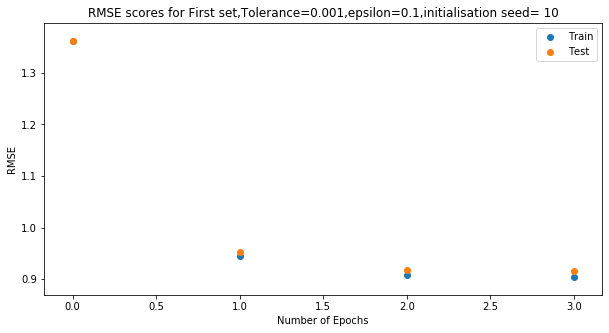

In [28]:
                                  
U_matrix,V_matrix=initialise_U_V(10,0.5)

#for i in range(4):
    #uv(rating_matrices[i], U_matrix,V_matrix ,0.001,tests[i],i)
%time uv(rating_matrices[4], U_matrix,V_matrix ,0.01,tests_5,4)


   


### Cross Validation for 5 sets
Choose one model for all evaluations (same tolerance, epsilon and random seed for initialising U and V.

In [19]:
# CROSS VALIDATION      
print(np.mean(final_results_rmse_train))
print(np.mean(final_results_mae_train))
print(np.mean(final_results_rmse_test))
print(np.mean(final_results_mae_test))

0.9015308376088138
0.8444395442888686
0.9124006599480865
0.8494379853238689


### Plot the RMSE scores for every 1000 updates 

### <font color="red">(THIS IS ONLY FOR PRODUCING PLOTS. Note: this may take longer to run, since now every 1000 updates the rmse needs to be calculated for train and test sets)</font>


Original RMSE of random configuration:
1.1166982341762692
Original Test set RMSE fo initial random UV configuration:
1.1185170037861538
RMSE after this epoch on Training set
0.9166843702588401
MAE after this epoch on Training Set
0.8550099784883994
Test set RMSE:
0.9265972995708914
RMSE after this epoch on Training set
0.9032933542568408
MAE after this epoch on Training Set
0.8458700875044403
Test set RMSE:
0.9147782212553798
RMSE after this epoch on Training set
0.9013769925103258
MAE after this epoch on Training Set
0.84425795368541
Test set RMSE:
0.9132438082621712
RMSE after this epoch on Training set
0.9008460480543432
MAE after this epoch on Training Set
0.8437821559438508
Test set RMSE:
0.9128109211272446


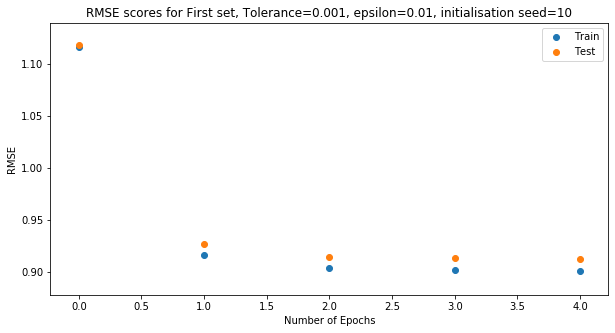

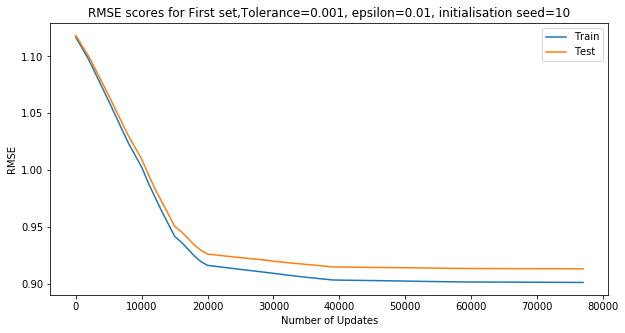

Wall time: 3min 25s


In [16]:
   

def uv_plot(M,U,V,tolerance,test_set):
    
    row_positions_not_blank=[]
    column_positions_not_blank=[]
    
    for i in range(len(M[:,1])):
        row_positions_not_blank.append(np.array(np.ndarray.flatten((np.argwhere(np.isfinite(M[i,:]))))))
    
    for i in range(len(M[1,:])):
        column_positions_not_blank.append((np.argwhere(np.isfinite(M[:,i]))))
    
    all_not_blank_positions=np.argwhere(np.isfinite(M))   # store indeces of non_blanks and only run loops over these
    P=np.matmul(U,V)

    total_non_blanks=len(all_not_blank_positions)          
    
    rmse_epochs=[]            # store rmse values for every epoch on training set
    rmse_test_epochs=[]
    
    rmse_1000_updates=[]      # store the rmse values after every 1000 updates  on training set
    rmse_test_1000_updates=[]
    
    
    
    updates_count=[0]        #array for storing the number of elements updated, use for plotting rmse
    updates_counter=0                   #counts the total number of updated Matrix elements 
    
    
    #Original RMSE 
    squared_errors=0
    for i,j in all_not_blank_positions:
        squared_errors+=(M[i,j]-P[i,j])**2
    rmse=ma.sqrt(squared_errors/total_non_blanks)
    rmse_epochs.append(rmse)
    rmse_1000_updates.append(rmse)
    print("Original RMSE of random configuration:")
    print(rmse)                  
    
    #Original MAE
    mae=0
    abs_errors=0
    for i,j in all_not_blank_positions:
        abs_errors+=np.abs((M[i,j]-P[i,j]))
    #print("Original MAE of random configuration")  
    #print(ma.sqrt(abs_errors/total_non_blanks))
    
    #Original Test RMSE for starting UV configuration
    rmse_test=0
    squared_errors=0
    for i in range(len(test_set[:,0])):
        user_index=int(test_set[i,0])-1
        movie_index=int(test_set[i,1])-1
        Rating=test_set[i,2]
        squared_errors+=(Rating-P[user_index,movie_index])**2
    new_epoch_test_rmse=ma.sqrt(squared_errors/(len(test_set[:,0])))
    rmse_test_epochs.append(new_epoch_test_rmse)
    rmse_test_1000_updates.append(new_epoch_test_rmse)
    print("Original Test set RMSE fo initial random UV configuration:")
    print(new_epoch_test_rmse)
    
    
     
    epoch_counter=0                     #counts the present epoch
    new_epoch_rmse=1000                 # set to large value initially to run first epoch
    
    #run UV decomp epoch until convergence
    
    while np.abs(new_epoch_rmse-rmse)>tolerance:
        rmse=new_epoch_rmse
        epoch_counter+=1
        perms_n , perms_m =create_permutation()
    
    
    
        for count in range(6040):
            r=perms_n[count]
            #Update V values 
            if count<3706:
        
                s=perms_m[count]
                #first row
                if not len(column_positions_not_blank[s])==0:  # taking care of cases where movie is not present in the training set
        
                    element=V[0,s]
                    denominator=0
                    numerator=0
                    new_element=0
        
                    for i in column_positions_not_blank[s]:
                 
                
                        numerator+=(U[i,0]*(M[i,s] -(U[i,1]*V[1,s])))
                        denominator+=(U[i,0]**2)
                   
                    new_element=numerator/denominator
        
                    V[0,s]=(new_element+element)/2      # set value to half way between optimal and original
                    updates_counter+=1
                #second row
                if not len(column_positions_not_blank[s])==0:
            
        
                    element=V[1,s]
                    denominator=0
                    numerator=0
                    new_element=0
        
                    for i in column_positions_not_blank[s]:
                 
                
                        numerator+=(U[i,1]*(M[i,s] -(U[i,0]*V[0,s])))
                        denominator+=(U[i,1]**2)
           
                    new_element=numerator/denominator
        
                    V[1,s]=(new_element+element)/2   # set value to half way between optimal and original
                    updates_counter+=1

            #Update U values
        
            #first column
            element=U[r,0]
            denominator=0
            numerator=0
            new_element=0
        
            for j in row_positions_not_blank[r]:
                numerator+=(V[0,j]*(M[r,j] -(U[r,1]*V[1,j])))
                denominator+=(V[0,j]**2)
        
            new_element=numerator/denominator
            U[r,0]=(new_element+element)/2       # set value to half way between optimal and original
            updates_counter+=1
            
            #second column
            element=U[r,1]
            denominator=0
            numerator=0
            new_element=0
        
            for j in row_positions_not_blank[r]:
                numerator+=(V[1,j]*(M[r,j] -(U[r,0]*V[0,j])))
                denominator+=(V[1,j]**2)
        
            new_element=numerator/denominator
            U[r,1]=(new_element+element)/2      # set value to half way between optimal and original
            updates_counter+=1
            
        #### Results every 1000 updates
            if updates_counter %1000 ==0:
                P=np.matmul(U,V)
                updates_count.append(updates_counter)
                
                #test
                rmse_test=0
                squared_errors=0
                for i in range(len(test_set[:,0])):
                    user_index=int(test_set[i,0])-1
                    movie_index=int(test_set[i,1])-1
                    Rating=test_set[i,2]
                    squared_errors+=(Rating-P[user_index,movie_index])**2
                new_epoch_test_rmse=ma.sqrt(squared_errors/(len(test_set[:,0])))
                rmse_test_1000_updates.append(new_epoch_test_rmse)
 
                
                #train
                squared_errors=0
                for i,j in all_not_blank_positions:
                    squared_errors+=(M[i,j]-P[i,j])**2       
    
                new_updates_rmse=ma.sqrt(squared_errors/total_non_blanks)
                rmse_1000_updates.append(new_updates_rmse)

    
    ####  Results of UV epoch     ####
        P=np.matmul(U,V)  # updated P matrix
        P[P>5]=5
        P[P<1]=1
        squared_errors=0
        for i,j in all_not_blank_positions:
            squared_errors+=(M[i,j]-P[i,j])**2       
    
        new_epoch_rmse=ma.sqrt(squared_errors/total_non_blanks)
        rmse_epochs.append(new_epoch_rmse)
        print("RMSE after this epoch on Training set")
        print(new_epoch_rmse)
    
        mae=0
        abs_errors=0
        for i,j in all_not_blank_positions:
            abs_errors+=np.abs((M[i,j]-P[i,j]))
        print("MAE after this epoch on Training Set")
        print(ma.sqrt(abs_errors/total_non_blanks))
        
        # TEST SET RMSE and MAE  #
        
        rmse_test=0
        squared_errors=0
        for i in range(len(test_set[:,0])):
            user_index=int(test_set[i,0])-1
            movie_index=int(test_set[i,1])-1
            Rating=test_set[i,2]
            squared_errors+=(Rating-P[user_index,movie_index])**2
        new_epoch_test_rmse=ma.sqrt(squared_errors/(len(test_set[:,0])))
        rmse_test_epochs.append(new_epoch_test_rmse)
        print("Test set RMSE:")
        print(new_epoch_test_rmse)


    # Plot graphs 
    #print(rmse_epochs)
    #print(rmse_test_epochs)
    plt.scatter(range(epoch_counter+1),rmse_epochs,label="Train")
    plt.scatter(range(epoch_counter+1),rmse_test_epochs,label="Test")
    plt.xlabel("Number of Epochs")
    plt.ylabel("RMSE")
    plt.title("RMSE scores for First set, Tolerance=0.001, epsilon=0.01, initialisation seed=10")
    plt.legend()
    plt.show()
    
    
    plt.plot(updates_count,rmse_1000_updates,label="Train")
    plt.plot(updates_count,rmse_test_1000_updates,label="Test")
    plt.xlabel("Number of Updates")
    plt.ylabel("RMSE")
    plt.title("RMSE scores for First set,Tolerance=0.001, epsilon=0.01, initialisation seed=10")
    #plt.xlim(15000, 80000)               # change range to better view rmse 
    plt.legend()
    plt.show()
    
            
            
    
        
    
        


U_matrix,V_matrix=initialise_U_V(10,0.01)
%time uv_plot(rating_matrices[0], U_matrix,V_matrix ,0.001,tests[0])    
    




# Matrix Factorisation
#### Steps:
<font color="green">(Step 1)</font> Define a function that randomly initialises the 6040 user vectors {$\vec{u}$} and the 3706 movie vectors {$\vec{v}$}, such that all their entries range between 0.59 and 0.62, chosen s.t initially $\vec{u}_i$ $\cdot \vec{v}_j $$\approx$ global average .
    

<font color="green">(Step 2)</font> Define the matrix factorisation function that takes in parameters
(training rating matrix, test_set,test_set index,regularization_controlled_by_lambda = 0.05, learning_rate = 0.005,number_of_features = 10, seed for inititalising {$\vec{u}$} and {$\vec{v}$} =10, number_of_iteration = 75)
    
<font color="green">(Step 3)</font> This function finds optimum {$\vec{u}$} and {$\vec{v}$} by looping over non-blank entries of $M$ and applying the update rules. Only two loops required, one for the number of iterations or epochs and one for looping over non-blank entries (avoiding nan entries of $M$.
    
<font color="green">(Step 4)</font> Run for all 5 sets, storing the final RMSE and MAE train and test results

    




In [55]:
#######################################################################
#             STEP 1
######################################################################


def create_u_and_v(features,seed):
    np.random.seed=seed
    all_u=np.random.uniform(0.59,0.62,(6040,features))
    all_v=np.random.uniform(0.59,0.62,(3706,features))
    return all_u,all_v
    
gravity_RMSE_train=[0]*5
gravity_RMSE_test=[0]*5
gravity_MAE_train=[0]*5
gravity_MAE_test=[0]*5
    
#####################################################################
#            Step 2
######################################################################
def gravity(M,test_set,set_index,lamb,lrate,features,seed,iterations):
    
    all_u ,all_v = create_u_and_v(features,seed)
    all_not_blank_positions=np.argwhere(np.isfinite(M))
    total_non_blanks=len(all_not_blank_positions)
    
   
    
###################################################################
#            Step 3
###################################################################
    for k in range(iterations):
        for i ,j in all_not_blank_positions:
            
            error= (M[i,j]- np.dot(all_u[i,:],all_v[j,:]))
            
      
            all_u[i]+= lrate*(   (error*all_v[j,:]) - (lamb*all_u[i,:])   )     #update rules
        
            all_v[j]+= lrate*(    (error*all_u[i,:]) - (lamb*all_v[j,:])   )    #updates rules
        
#####################################################################
#            Step 4
#####################################################################

    #Find train RMSE and MAE after final iteration
    
    abs_errors=0
    squared_errors=0
    for i,j in all_not_blank_positions:
        squared_errors+= (M[i,j] - np.dot(all_u[i],all_v[j]))**2
        abs_errors+=np.abs(M[i,j] - np.dot(all_u[i,:],all_v[j,:]))
        
    grav_rmse=ma.sqrt(squared_errors/total_non_blanks)    
    gravity_RMSE_train[set_index]=grav_rmse
    
    grav_mae=ma.sqrt(abs_errors/total_non_blanks)    
    gravity_MAE_train[set_index]=grav_mae
        
    #Find test RMSE and MAE after final iteration
    
    mae_test=0
    abs_errors=0
    rmse_test=0
    squared_errors=0
    for i in range(len(test_set[:,0])):
            user_index=int(test_set[i,0])-1
            movie_index=int(test_set[i,1])-1
            Rating=test_set[i,2]
            
            squared_errors+=(Rating-np.dot(all_u[user_index,:],all_v[movie_index,:]))**2
            abs_errors+=np.abs(Rating-np.dot(all_u[user_index,:],all_v[movie_index,:]))   
            
            
    grav_test=ma.sqrt(squared_errors/(len(test_set[:,0])))
    gravity_RMSE_test[set_index]=grav_test
        
    mae_test=ma.sqrt(abs_errors/(len(test_set[:,0])))
    gravity_MAE_test[set_index]=mae_test


### Run matrix factorisation for 5 sets, storing results and then take CV average:
#### <font color="red">Will take approx 1 hour to run</font>
The paramaters being: num factors=10, num iter=75, regularization=0.05, learn rate=0.005 and seed=10


In [57]:
%time gravity(rating_matrices[0],trains[0],0,0.05,0.005,10,10,75)
%time gravity(rating_matrices[1],trains[1],1,0.05,0.005,10,10,75)
%time gravity(rating_matrices[2],trains[2],2,0.05,0.005,10,10,75)
%time gravity(rating_matrices[3],trains[3],3,0.05,0.005,10,10,75)
%time gravity(rating_matrices[4],trains_5,4,0.05,0.005,10,10,75)
 

print("RMSE train CV average results:")
print(np.mean(gravity_RMSE_train))
print("RMSE test CV average results:")
print(np.mean(gravity_RMSE_test))
print("MAE train CV average results:")
print(np.mean(gravity_MAE_train))
print("MAE test CV average results:")
print(np.mean(gravity_MAE_test))

Wall time: 13min 53s
Wall time: 13min 56s
Wall time: 13min 47s
Wall time: 13min 53s
Wall time: 13min 47s
RMSE train CV average results:
0.7943339691893125
RMSE test CV average results:
0.794333969189313
MAE train CV average results:
0.7935106684922311
MAE test CV average results:
0.7935106684922386


## Matrix Factorisation: Plot RMSE for single test and train set:
### <font color="red">this will take even longer due to calculating RMSE after every iteration</font>
The paramaters being: num factors=10, num iter=75, regularization=0.05, learn rate=0.005 and seed=10

In [58]:
def create_u_and_v(features,seed):
    np.random.seed=seed
    all_u=np.random.uniform(0.59,0.62,(6040,features))
    all_v=np.random.uniform(0.59,0.62,(3706,features))
    return all_u,all_v
    
plot_RMSE_train=[]
plot_RMSE_test=[]

    
    
def gravity(M,test_set,set_index,lamb,lrate,features,seed,iterations):
    
    all_u ,all_v = create_u_and_v(features,seed)
    all_not_blank_positions=np.argwhere(np.isfinite(M))
    total_non_blanks=len(all_not_blank_positions)
    print(total_non_blanks)
    
    
    
    # Find Train RMSE beforehand
    
    squared_errors=0
    abs_errors=0
    for i,j in all_not_blank_positions:
        squared_errors+= (M[i,j] - np.dot(all_u[i,:],all_v[j,:]))**2
        
                            
    grav_rmse=ma.sqrt(squared_errors/total_non_blanks)
    plot_RMSE_train.append(grav_rmse)

                            
    # Find Test RMSE beforehand
    
    rmse_test=0
    squared_errors=0
    for i in range(len(test_set[:,0])):
            user_index=int(test_set[i,0])-1
            movie_index=int(test_set[i,1])-1
            Rating=test_set[i,2]
            
            squared_errors+=(Rating-np.dot(all_u[user_index,:],all_v[movie_index,:]))**2
            
            
            
    grav_test=ma.sqrt(squared_errors/(len(test_set[:,0])))
    plot_RMSE_test.append(grav_test)
    
    
###################################################################
                            #Run Matrix Factorisation
    
    for k in range(iterations):
        for i ,j in all_not_blank_positions:
             
            error= (M[i,j]- np.dot(all_u[i,:],all_v[j,:]))
      
            all_u[i]+= lrate*(   (error*all_v[j,:]) - (lamb*all_u[i,:])   )     #update rules
        
            all_v[j]+= lrate*(    (error*all_u[i,:]) - (lamb*all_v[j,:])   )    #updates rules
        
        
        #Find train RMSE after every iteration
    
        squared_errors=0
        for i,j in all_not_blank_positions:
            dot=np.dot(all_u[i],all_v[j])
            if dot >5:
                dot=5
            if dot<1:
                dot=1
            squared_errors+= (M[i,j] - dot)**2
        grav_rmse=ma.sqrt(squared_errors/total_non_blanks)
    
        plot_RMSE_train.append(grav_rmse)
        
       # Find Test RMSE after every iteration
    
        squared_errors=0
        for i in range(len(test_set[:,0])):
            user_index=int(test_set[i,0])-1
            movie_index=int(test_set[i,1])-1
            Rating=test_set[i,2]
            dot=np.dot(all_u[user_index,:],all_v[movie_index,:])
            if dot >5:
                dot=5
            if dot<1:
                dot=1
            
            squared_errors+=(Rating-dot)**2
        grav_rmse=ma.sqrt(squared_errors/(len(test_set[:,0])))
    
        plot_RMSE_test.append(grav_rmse)
        


### Plot RMSE graph for first set


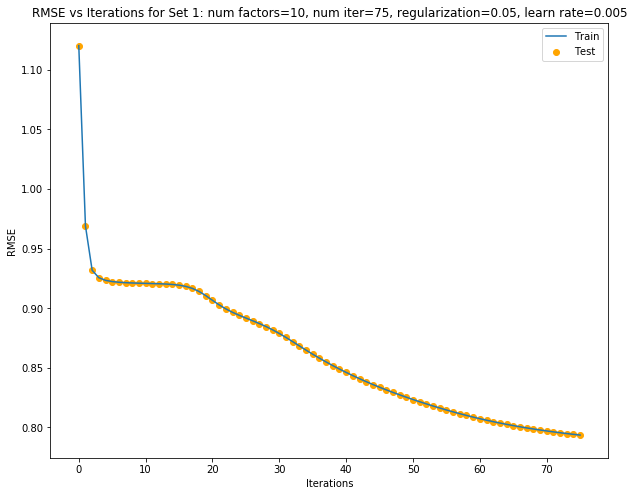

In [73]:
#num factors=10, num iter=75, regularization=0.05, learn rate=0.005.

#gravity(M,test_set,set_index,lamb,lrate,features,seed,iterations):
%time gravity(rating_matrices[0],trains[0],0,0.05,0.005,10,10,75)

plt.rcParams['figure.figsize'] = [10, 8] 
x=range(76)
plt.plot(x,plot_RMSE_train,label="Train")
plt.scatter(x,plot_RMSE_test,label="Test",c='orange')
plt.xlabel("Iterations")
plt.ylabel("RMSE")
plt.title("RMSE vs Iterations for Set 1: num factors=10, num iter=75, regularization=0.05, learn rate=0.005")
plt.legend()
plt.show()




